#  Finding Optional Shared Streets

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.ops import unary_union
import util
import seaborn as sns
import numpy as np
from matplotlib import cm, colors
import matplotlib.pyplot as plt

# Enable OSMNX cache
ox.config(use_cache=True)

## Objective

Selecting streets for conversion to a shared or open street is not trivial. 
Factors such as traffic impact and proper consideration to those affected need to be address.
This project aims to find and suggest roadways which can positively impact communities in Denver while minimizing impact on traffic.

## Data Sources

* OSMNX & Open Streets (“© OpenStreetMap contributors” via the Open Database License)
* City of Denver Open Data Catalog (CC BY 3.0)




### Load Denver Street Data

In [3]:
denver = ox.graph_from_place("Denver, Colorado, USA", network_type="drive")

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


### Add Data to Graphs

In [4]:
denver = util.add_speeds_to_graph(denver)
denver = util.drive_network_to_capacitated_network(denver)

### Focus on Particular Neighborhoods

In [5]:
neighborhoods = gpd.read_file(
    "../data/statistical_neighborhoods.gdb", driver="OpenFileGDB"
)

neighborhoods_of_focus = [
    "CBD",
    "Capitol Hill",
    "City Park West",
    "Five Points",
    "North Capitol Hill"
]

In [6]:
focus_poly = unary_union(neighborhoods[neighborhoods["NBHD_NAME"].isin(neighborhoods_of_focus)].geometry.values)
focus_network = ox.truncate.truncate_graph_polygon(denver, focus_poly)

In [13]:
print(focus_network)
for i,j,_ in focus_network.edges:
    print(i,j)

MultiDiGraph with 674 nodes and 1855 edges
176064699 176109088
176066218 176088631
176066218 176102962
176066218 176095814
176070171 1160471898
176070171 176072805
176070171 176071279
176070187 176105202
176070187 176072803
176070901 176072931
176071022 176071024
176071022 176112282
176071022 2828141542
176071022 176085434
176071024 176081505
176071024 176081503
176071024 176071026
176071024 176071022
176071026 176086617
176071026 589371149
176071026 176071028
176071026 176071024
176071028 5499342734
176071028 176097606
176071028 176071030
176071028 176071026
176071030 176097607
176071030 176102608
176071030 176071032
176071030 176071028
176071032 3039719143
176071032 176086901
176071032 176071030
176071032 176086903
176071275 6069441013
176071275 3376084229
176071277 3376084228
176071277 176071279
176071277 176080651
176071279 176071280
176071279 176071277
176071279 176080653
176071279 176070171
176071280 176071281
176071280 176071279
176071280 176072805
176071281 176071282
176071281 

## Choosing Candidate Streets

Before analyzing the impact on traffic, we select streets which a reasonable candidates based on factors such as
* Pedestrian Demand
* Equity Indices
* Park Access
* School Access
* and Transit Stops.

A more through discussion of the selection process can be found in the notebook [Best Neighborhood Streets](./BestNeighborhoodsStreets.ipynb).

### Load up candidate streets

In [7]:
candidate_streets = gpd.read_file("../processed/candidate_streets.shp")\
    .set_crs(epsg=util.CONFIG.base_crs)\
    .set_index(["u", "v", "key"])
candidate_streets.head()

NCH_EVENTS      highway  oneway   length maxspeed  \
u         v          key                                                      
176086235 4955447713 0      2.898148    secondary       1  105.643   30 mph   
          176086237  0      2.725926  residential       0  146.534     None   
176097378 176086237  0      2.637037     tertiary       0  105.853     None   
176095479 176086237  0      2.535185     tertiary       0  102.724     None   
176086237 176086239  0      2.501852  residential       0  149.367     None   

                           ref access bridge tunnel  index_righ  ...  \
u         v          key                                         ...   
176086235 4955447713 0    None   None   None   None           5  ...   
          176086237  0    None   None   None   None           5  ...   
176097378 176086237  0    None   None   None   None           5  ...   
176095479 176086237  0    None   None   None   None           5  ...   
176086237 176086239  0    None   None   None   None           5  ...   

                         AVG_PDI_SC  AVG_PDI_10  PDI_EQUITY  SHAPE_Leng  \
u         v          key                                                  
176086235 4955447713 0     8.916667    9.950766    4.206085    0.040371   
          176086237  0     8.916667    9.950766    4.206085    0.040371   
176097378 176086237  0     8.916667    9.950766    4.206085    0.040371   
176095479 176086237  0     8.916667    9.950766    4.206085    0.040371   
176086237 176086239  0     8.916667    9.950766    4.206085    0.040371   

                          SHAPE_Area  CPW_EVENTS  CH_EVENTS  FP_EVENTS  \
u         v          key                                                 
176086235 4955447713 0      0.000096         NaN        NaN        NaN   
          176086237  0      0.000096         NaN        NaN        NaN   
176097378 176086237  0      0.000096         NaN        NaN        NaN   
176095479 176086237  0      0.000096         NaN        NaN        NaN   
176086237 176086239  0      0.000096         NaN        NaN        NaN   

                          CBD_EVENTS  \
u         v          key               
176086235 4955447713 0           NaN   
          176086237  0           NaN   
176097378 176086237  0           NaN   
176095479 176086237  0           NaN   
176086237 176086239  0           NaN   

                                                                   geometry  
u         v          key                                                     
176086235 4955447713 0    LINESTRING (-104.98110 39.74486, -104.98122 39...  
          176086237  0    LINESTRING (-104.98110 39.74486, -104.98110 39...  
176097378 176086237  0    LINESTRING (-104.98233 39.74618, -104.98222 39...  
176095479 176086237  0    LINESTRING (-104.97989 39.74618, -104.98000 39...  
176086237 176086239  0    LINESTRING (-104.98109 39.74618, -104.98109 39...  

[5 rows x 28 columns]

### Plot Candidate Streets

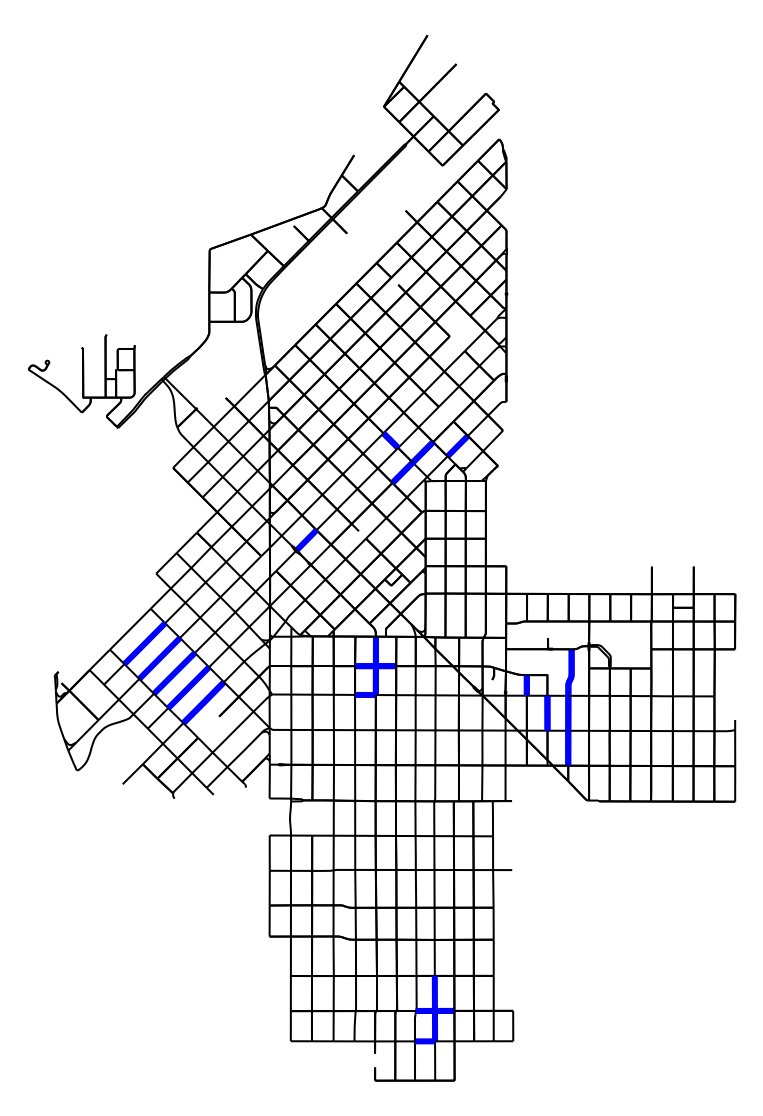

In [8]:
ec_candidate = ['blue' if (edge in candidate_streets.index or (edge[1], edge[0], edge[2]) in candidate_streets.index) else 'black' for edge in focus_network.edges]
lw_candidate = [3 if (edge in candidate_streets.index or (edge[1], edge[0], edge[2]) in candidate_streets.index) else 1 for edge in focus_network.edges]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig, ax = ox.plot_graph(focus_network, node_size=1, edge_color=ec_candidate, node_alpha=0, edge_linewidth=lw_candidate, ax=ax, show=False)

### Areas of Concern for Traffic

<AxesSubplot:>

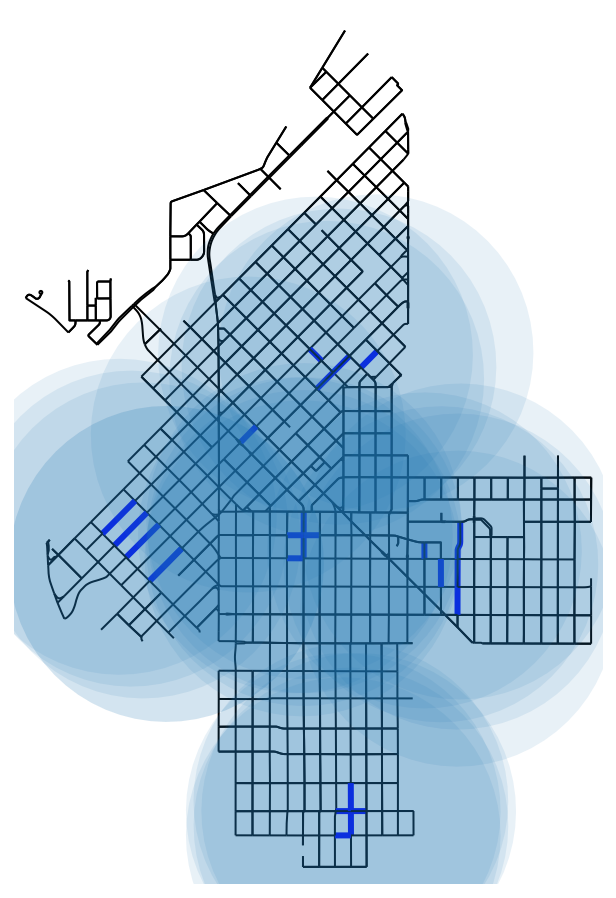

In [9]:
fig, ax = ox.plot_graph(focus_network, node_size=1, edge_color=ec_candidate, node_alpha=0, bgcolor="white", edge_linewidth=lw_candidate, show=False)
candidate_streets.to_crs(epsg=util.CONFIG.local_crs).geometry.representative_point().buffer(1000).to_crs(epsg=util.CONFIG.base_crs).plot(ax=ax, alpha=0.1)

In [9]:
def removal_impact(
    network: nx.DiGraph,
    arc: (int, int, int),
    radius: float, 
) -> float:
    
    net = nx.DiGraph(network)
    edges = ox.utils_graph.graph_to_gdfs(network, edges=True, nodes=False)
    area_of_interest = edges.loc[[arc]].to_crs(epsg=util.CONFIG.local_crs) \
        .geometry.representative_point().buffer(radius) \
        .to_crs(epsg=util.CONFIG.base_crs).iloc[0]
    
    net = nx.DiGraph(ox.truncate.truncate_graph_polygon(net, area_of_interest))
    
    unperturbed_flow_values, _unperturbed_flows = util.all_pairs_max_flow(net, net.nodes)
    net.get_edge_data(arc[0], arc[1])["capacity"] = 0
    if (arc[1], arc[0]) in net.edges:
        net.get_edge_data(arc[1], arc[0])["capacity"] = 0
    
    perturbed_flow_values, _perturbed_flows = util.all_pairs_max_flow(net, net.nodes)
    return {x: perturbed_flow_values[x] - unperturbed_flow_values[x] for x in perturbed_flow_values.keys()}

In [10]:
impacts = {}

for candidate in candidate_streets.index:
    impacts[candidate] = removal_impact(denver, candidate, 1000)

All pairs Max Flow: 100%|███████████████████████████████████████████| 2040/2040 [01:14<00:00, 27.33it/s]
All pairs Max Flow: 2137it [01:16, 28.07it/s]                                                           
All pairs Max Flow: 2137it [01:14, 28.87it/s]                                                           
All pairs Max Flow: 2137it [01:11, 30.06it/s]                                                           
All pairs Max Flow: 2137it [01:12, 29.65it/s]                                                           
All pairs Max Flow: 2170it [01:12, 29.82it/s]                                                           
All pairs Max Flow: 2170it [01:13, 29.67it/s]                                                           
All pairs Max Flow: 2287it [01:16, 29.84it/s]                                                           
All pairs Max Flow: 2287it [01:19, 28.95it/s]                                                           
All pairs Max Flow: 1690it [00:51, 33.08it/s]          

In [11]:
mean_impacts = {k: np.mean(list(v.values())) for (k, v) in impacts.items()}

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


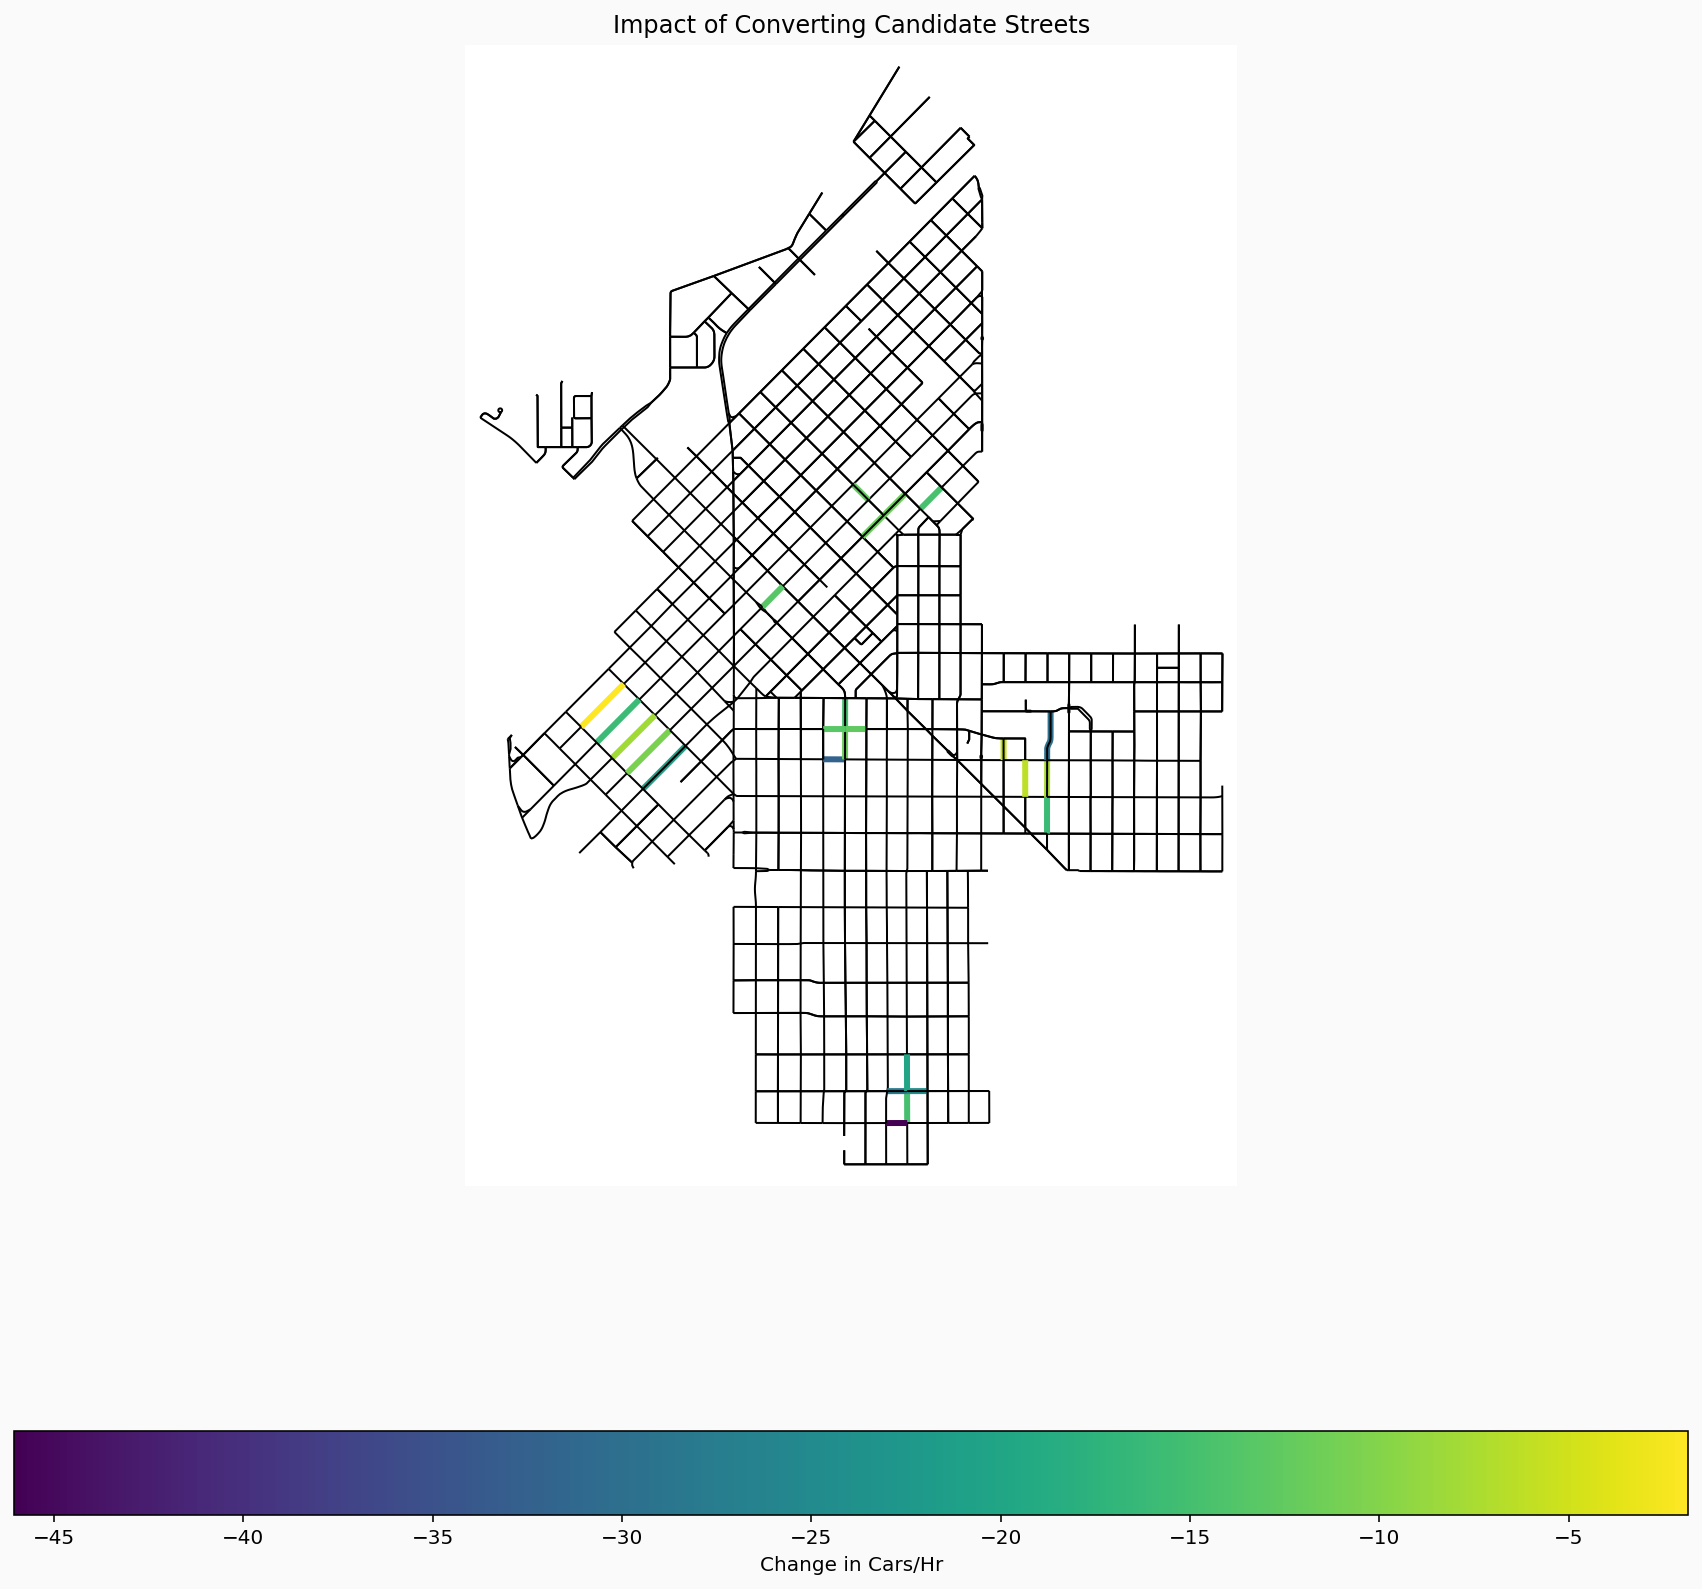

In [16]:
impact_norm = colors.Normalize()
impact_norm.autoscale(list(mean_impacts.values()))

ec_impacts = [cm.viridis(impact_norm(mean_impacts[edge])) if edge in mean_impacts else 'black' for edge in focus_network.edges]
lw_candidate = [3 if edge in candidate_streets.index else 1 for edge in focus_network.edges]
fig, ax = plt.subplots(1, 1, figsize=(15, 15), facecolor='#fafafa')
ox.plot_graph(focus_network, node_size=1, edge_color=ec_impacts, node_alpha=0, bgcolor="#fafafa", edge_linewidth=lw_candidate, show=False, ax=ax)

cb = fig.colorbar(
    cm.ScalarMappable(norm=impact_norm, cmap=cm.viridis), ax=ax, orientation="horizontal"
)
cb.ax.set_xlabel('Change in Cars/Hr')

ax.set_title("Impact of Converting Candidate Streets");

In [15]:
mean_impacts

{(176086235, 4955447713, 0): -32.08808891340751,
 (176086235, 176086237, 0): -11.741217923738995,
 (176097378, 176086237, 0): -13.377230632110775,
 (176095479, 176086237, 0): -12.648860901942967,
 (176086237, 176086239, 0): -14.889553138956224,
 (2841044065, 3358646006, 0): -5.489840670082133,
 (176093803, 2841030937, 0): -30.12852198078015,
 (4435531507, 176080675, 0): -6.174943350691725,
 (176080677, 176093803, 0): -7.476381754500151,
 (176080677, 176071297, 0): -15.865310952465109,
 (3442474977, 3405259189, 0): -20.136298877271727,
 (3442474977, 3442481922, 0): -24.267819623287075,
 (1341986925, 3442474977, 0): -28.010889758091412,
 (176089093, 176089091, 0): -46.04965943025756,
 (176089093, 3442474977, 0): -14.870120635056216,
 (176092317, 176092319, 0): -11.84771569668949,
 (5450871313, 176110575, 0): -13.476388295484254,
 (176085817, 176085819, 0): -14.785596050270904,
 (176092315, 176092317, 0): -11.863845792635626,
 (176104953, 176104957, 0): -12.466654799107857,
 (176094619, 1

In [19]:
denver.get_edge_data(176086235, 4955447713)[0]

{'osmid': 130919107,
 'oneway': True,
 'lanes': '3',
 'name': 'East 18th Avenue',
 'highway': 'secondary',
 'maxspeed': '30 mph',
 'length': 105.643,
 'geometry': <shapely.geometry.linestring.LineString at 0x14e640910>,
 'speed_kph': 48.3,
 'capacity': 4210.985104315016}

In [21]:
denver.nodes[176086235]

{'y': 39.7448636, 'x': -104.981098, 'street_count': 4}

In [25]:
denver.edges(176086235, data="name")

OutMultiEdgeDataView([(176086235, 4955447713, 'East 18th Avenue'), (176086235, 176080657, 'Pennsylvania Street'), (176086235, 176086237, 'Pennsylvania Street')])

In [41]:
items = []
for edge, impact in sorted(mean_impacts.items(), key=lambda x: -x[1]):
    road_name = denver.get_edge_data(edge[0], edge[1])[0]["name"]
    adjacent_roads_left = ", ".join(set([str(x[2]) for x in denver.edges(edge[0], data="name") if x[2] != road_name]))
    adjacent_roads_right = ", ".join(set([str(x[2]) for x in denver.edges(edge[1], data="name") if x[2] != road_name]))
    items.append({"impact": impact, "road": road_name, "between_left": adjacent_roads_left, "between_right": adjacent_roads_right})
    
best_table = pd.DataFrame.from_records(items)

best_table

,impact,road,between_left,between_right
0,-1.840404,Curtis Street,15th Street,17th Street
1,-5.489841,Marion Street,East 18th Avenue,"['East 19th Avenue', 'Lafayette Street'], East..."
2,-6.174943,Lafayette Street,"East 18th Avenue, ['East 19th Avenue', 'Lafaye...",East 17th Avenue
3,-7.476382,Humboldt Street,East 17th Avenue,East 18th Avenue
4,-8.202974,Stout Street,15th Street,17th Street
5,-10.693114,California Street,17th Street,15th Street
6,-11.741218,Pennsylvania Street,East 18th Avenue,East 19th Avenue
7,-11.847716,California Street,27th Street,28th Street
8,-11.863846,California Street,26th Street,27th Street
9,-12.466655,27th Street,Stout Street,Champa Street
